In [1]:
import re
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
def select_gpu(N):
    gpus = tf.config.experimental.list_physical_devices('GPU')
    print(gpus)
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_visible_devices(gpus[N], 'GPU')
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            print(e)    

In [3]:
select_gpu(0)
epochs = 512
batch_size = 1024
model_name = 'bert-chinese'
embedding_path = '/home/Danny/pretrain_model/{}'.format(model_name)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]
3 Physical GPUs, 1 Logical GPUs


In [4]:
# 不用儲存article_id, 轉成list
def training_txt_to_list(path):
    with open(path, 'r') as f:
        txt = str(f.read())
    txt_list = txt.split('\n')
    text_label_list = list()
    tmp = list()
    for line in txt_list:
        if line == '--------------------':
            text_label_list.append(tmp)
            tmp = list()
            continue
        if line == '':
            continue
        tmp.append(line)
    x = list()
    y = list()
    for text_label in text_label_list:
        text = text_label[0]
        label = text_label[2:]
        label_list = ['O' for i in range(len(text))]
        for i in label:
            entity = i.split('\t')
            if int(entity[1]) > int(entity[2]):
                continue
            b = int(entity[1])
            label_list[b] = 'B-{}'.format(entity[-1])
            for j in range(int(entity[1])+1, int(entity[2])):
                label_list[j] = 'I-{}'.format(entity[-1])
        for i, j in enumerate(text):
            if j == '，' or j == '。' or j == '？':
                label_list[i] = j
                
        text_list = re.split('\uff0c|\u3002|\uff1f', text)
        for sentence in text_list:
            x.append([i for i in sentence])
        x = x[:-1]
            
        sentence = list()
        for i in label_list:
            if i == '，' or i == '。' or i == '？':
                y.append(sentence)
                sentence = list()
            else:
                sentence.append(i)
                
    return [x, y]

In [5]:
x1, y1 = training_txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage1/SampleData_deid.txt')

In [6]:
x2, y2 = training_txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage2/train_1_update.txt')

In [7]:
x4, y4 = training_txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage4/train_2.txt')

In [8]:
x = x1 + x2 + x4
y = y1 + y2 + y4
print(len(x))
print(len(y))

76162
76162


In [9]:
df = pd.DataFrame({'x': x, 'y': y})
df

,x,y
0,"[醫, 師, ：, 你, 有, 做, 超, 音, 波, 嘛]","[O, O, O, O, O, O, O, O, O, O]"
1,"[那, 我, 們, 來, 看, 報, 告]","[O, O, O, O, O, O, O]"
2,"[有, 些, 部, 分, 有, 紅, 字, 耶]","[O, O, O, O, O, O, O, O]"
3,"[民, 眾, ：, 紅, 字, 是, 甚, 麼, 意, 思]","[O, O, O, O, O, O, O, O, O, O]"
4,"[醫, 師, ：, 就, 是, 肝, 功, 能, 有, 比, 較, 高]","[O, O, O, O, O, O, O, O, O, O, O, O]"
...,...,...
76157,"[醫, 師, ：, 他, 有, 在, 騎, 腳, 踏, 車]","[O, O, O, O, O, O, O, O, O, O]"
76158,"[民, 眾, ：, 恩]","[O, O, O, O]"
76159,"[醫, 師, ：, 騎, 腳, 踏, 車, 可, 以]","[O, O, O, O, O, O, O, O, O]"
76160,"[小, 美]","[B-name, I-name]"


In [10]:
clinical_event = pd.read_csv('/home/Danny/AI-CUP-2020/datasets/augmentation/clinical_event.csv')
contact = pd.read_csv('/home/Danny/AI-CUP-2020/datasets/augmentation/contact.csv')
education = pd.read_csv('/home/Danny/AI-CUP-2020/datasets/augmentation/education.csv')
family = pd.read_csv('/home/Danny/AI-CUP-2020/datasets/augmentation/family.csv')
profession = pd.read_csv('/home/Danny/AI-CUP-2020/datasets/augmentation/profession.csv')

In [11]:
df = df.append(clinical_event)
df = df.append(contact)
df = df.append(education)
df = df.append(family)
df = df.append(profession)
df

,x,y
0,"[醫, 師, ：, 你, 有, 做, 超, 音, 波, 嘛]","[O, O, O, O, O, O, O, O, O, O]"
1,"[那, 我, 們, 來, 看, 報, 告]","[O, O, O, O, O, O, O]"
2,"[有, 些, 部, 分, 有, 紅, 字, 耶]","[O, O, O, O, O, O, O, O]"
3,"[民, 眾, ：, 紅, 字, 是, 甚, 麼, 意, 思]","[O, O, O, O, O, O, O, O, O, O]"
4,"[醫, 師, ：, 就, 是, 肝, 功, 能, 有, 比, 較, 高]","[O, O, O, O, O, O, O, O, O, O, O, O]"
...,...,...
495,"['那', '個', '時', '候', '是', '白', '天', '釣', '具', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-profess..."
496,"['因', '為', '我', '是', '還', '是', '網', '球', '球', ...","['O', 'O', 'O', 'O', 'O', 'O', 'B-profession',..."
497,"['醫', '師', '：', '你', '是', '採', '椰', '子', '工', ...","['O', 'O', 'O', 'O', 'O', 'B-profession', 'I-p..."
498,"['安', '養', '院', '工', '作', '人', '員']","['B-profession', 'I-profession', 'I-profession..."


In [13]:
df['x'] = df['x'].apply(lambda row : str(row))
df['y'] = df['y'].apply(lambda row : str(row))
# df = df.drop_duplicates()
df['x'] = df['x'].apply(lambda row : eval(row))
df['y'] = df['y'].apply(lambda row : eval(row))
df

,x,y
0,"[醫, 師, ：, 你, 有, 做, 超, 音, 波, 嘛]","[O, O, O, O, O, O, O, O, O, O]"
1,"[那, 我, 們, 來, 看, 報, 告]","[O, O, O, O, O, O, O]"
2,"[有, 些, 部, 分, 有, 紅, 字, 耶]","[O, O, O, O, O, O, O, O]"
3,"[民, 眾, ：, 紅, 字, 是, 甚, 麼, 意, 思]","[O, O, O, O, O, O, O, O, O, O]"
4,"[醫, 師, ：, 就, 是, 肝, 功, 能, 有, 比, 較, 高]","[O, O, O, O, O, O, O, O, O, O, O, O]"
...,...,...
495,"[那, 個, 時, 候, 是, 白, 天, 釣, 具, 製, 造, 工, 人]","[O, O, O, O, O, O, O, B-profession, I-professi..."
496,"[因, 為, 我, 是, 還, 是, 網, 球, 球, 員, 嘛]","[O, O, O, O, O, O, B-profession, I-profession,..."
497,"[醫, 師, ：, 你, 是, 採, 椰, 子, 工, 是, 不, 是]","[O, O, O, O, O, B-profession, I-profession, I-..."
498,"[安, 養, 院, 工, 作, 人, 員]","[B-profession, I-profession, I-profession, I-p..."


In [14]:
x = df['x'].to_list()
y = df['y'].to_list()

In [15]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))
print(len(test_x), len(test_y))

50151 50151
12538 12538
15673 15673


In [16]:
%%time
import kashgari
from kashgari.tasks.labeling import BiLSTM_CRF_Model
from kashgari.embeddings import BertEmbedding
kashgari.config.use_cudnn_cell = True
bert_embedding = BertEmbedding(embedding_path, 
                           sequence_length='auto',
                           trainable=True,
                           task='kashgari.LABELING', 
                          )
model = BiLSTM_CRF_Model(bert_embedding)
history = model.fit(train_x,
                    train_y,
                    valid_x,
                    valid_y,
                    epochs=epochs,
                    batch_size=batch_size,
                   )

2020-12-17 17:05:43,369 [DEBUG] kashgari - ------------------------------------------------
2020-12-17 17:05:43,370 [DEBUG] kashgari - Loaded transformer model's vocab
2020-12-17 17:05:43,370 [DEBUG] kashgari - config_path       : /home/Danny/pretrain_model/bert-chinese/bert_config.json
2020-12-17 17:05:43,370 [DEBUG] kashgari - vocab_path      : /home/Danny/pretrain_model/bert-chinese/vocab.txt
2020-12-17 17:05:43,371 [DEBUG] kashgari - checkpoint_path : /home/Danny/pretrain_model/bert-chinese/bert_model.ckpt
2020-12-17 17:05:43,371 [DEBUG] kashgari - Top 50 words    : ['[PAD]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]', '[unused9]', '[unused10]', '[unused11]', '[unused12]', '[unused13]', '[unused14]', '[unused15]', '[unused16]', '[unused17]', '[unused18]', '[unused19]', '[unused20]', '[unused21]', '[unused22]', '[unused23]', '[unused24]', '[unused25]', '[unused26]', '[unused27]', '[unused28]', '[unused29]', '[unused30]', '[

Epoch 1/512
48/48 [==============================] - 38s 784ms/step - loss: 2.2985 - accuracy: 0.9125 - val_loss: 25.5652 - val_accuracy: 0.9695
Epoch 2/512
48/48 [==============================] - 35s 726ms/step - loss: 0.7009 - accuracy: 0.9698 - val_loss: 25.4548 - val_accuracy: 0.9762
Epoch 3/512
48/48 [==============================] - 35s 728ms/step - loss: 0.4870 - accuracy: 0.9746 - val_loss: 25.3767 - val_accuracy: 0.9798
Epoch 4/512
48/48 [==============================] - 35s 732ms/step - loss: 0.3694 - accuracy: 0.9782 - val_loss: 25.2754 - val_accuracy: 0.9835
Epoch 5/512
48/48 [==============================] - 35s 735ms/step - loss: 0.2975 - accuracy: 0.9819 - val_loss: 25.1399 - val_accuracy: 0.9857
Epoch 6/512
48/48 [==============================] - 35s 735ms/step - loss: 0.2513 - accuracy: 0.9844 - val_loss: 25.0910 - val_accuracy: 0.9875
Epoch 7/512
48/48 [==============================] - 35s 736ms/step - loss: 0.2202 - accuracy: 0.9859 - val_loss: 25.0104 - val_ac

48/48 [==============================] - 36s 742ms/step - loss: 0.0225 - accuracy: 0.9982 - val_loss: 23.3312 - val_accuracy: 0.9895
Epoch 58/512
48/48 [==============================] - 36s 743ms/step - loss: 0.0234 - accuracy: 0.9981 - val_loss: 23.3117 - val_accuracy: 0.9896
Epoch 59/512
48/48 [==============================] - 36s 742ms/step - loss: 0.0218 - accuracy: 0.9981 - val_loss: 23.3084 - val_accuracy: 0.9895
Epoch 60/512
48/48 [==============================] - 36s 743ms/step - loss: 0.0219 - accuracy: 0.9982 - val_loss: 23.2775 - val_accuracy: 0.9893
Epoch 61/512
48/48 [==============================] - 36s 742ms/step - loss: 0.0207 - accuracy: 0.9982 - val_loss: 23.2728 - val_accuracy: 0.9880
Epoch 62/512
48/48 [==============================] - 36s 742ms/step - loss: 0.0205 - accuracy: 0.9983 - val_loss: 23.2355 - val_accuracy: 0.9879
Epoch 63/512
48/48 [==============================] - 36s 742ms/step - loss: 0.0201 - accuracy: 0.9982 - val_loss: 23.2063 - val_accuracy

48/48 [==============================] - 36s 742ms/step - loss: 0.0106 - accuracy: 0.9988 - val_loss: 22.0774 - val_accuracy: 0.0520
Epoch 114/512
48/48 [==============================] - 36s 742ms/step - loss: 0.0110 - accuracy: 0.9987 - val_loss: 22.0382 - val_accuracy: 0.0516
Epoch 115/512
48/48 [==============================] - 36s 743ms/step - loss: 0.0100 - accuracy: 0.9989 - val_loss: 22.0412 - val_accuracy: 0.0518
Epoch 116/512
48/48 [==============================] - 36s 742ms/step - loss: 0.0100 - accuracy: 0.9989 - val_loss: 22.0029 - val_accuracy: 0.0481
Epoch 117/512
48/48 [==============================] - 36s 741ms/step - loss: 0.0106 - accuracy: 0.9988 - val_loss: 21.9545 - val_accuracy: 0.0480
Epoch 118/512
48/48 [==============================] - 36s 741ms/step - loss: 0.0106 - accuracy: 0.9988 - val_loss: 21.9468 - val_accuracy: 0.0411
Epoch 119/512
48/48 [==============================] - 36s 747ms/step - loss: 0.0093 - accuracy: 0.9990 - val_loss: 21.9431 - val_ac

Epoch 169/512
48/48 [==============================] - 36s 742ms/step - loss: 0.0078 - accuracy: 0.9989 - val_loss: 20.4862 - val_accuracy: 0.0291
Epoch 170/512
48/48 [==============================] - 36s 742ms/step - loss: 0.0067 - accuracy: 0.9990 - val_loss: 20.4672 - val_accuracy: 0.0296
Epoch 171/512
48/48 [==============================] - 36s 741ms/step - loss: 0.0073 - accuracy: 0.9990 - val_loss: 20.4264 - val_accuracy: 0.0298
Epoch 172/512
48/48 [==============================] - 36s 742ms/step - loss: 0.0074 - accuracy: 0.9989 - val_loss: 20.3957 - val_accuracy: 0.0298
Epoch 173/512
48/48 [==============================] - 36s 743ms/step - loss: 0.0071 - accuracy: 0.9990 - val_loss: 20.3505 - val_accuracy: 0.0296
Epoch 174/512
48/48 [==============================] - 36s 742ms/step - loss: 0.0072 - accuracy: 0.9989 - val_loss: 20.3417 - val_accuracy: 0.0295
Epoch 175/512
48/48 [==============================] - 36s 743ms/step - loss: 0.0075 - accuracy: 0.9990 - val_loss: 20

Epoch 225/512
48/48 [==============================] - 36s 743ms/step - loss: 0.0066 - accuracy: 0.9989 - val_loss: 18.7755 - val_accuracy: 0.0211
Epoch 226/512
48/48 [==============================] - 36s 742ms/step - loss: 0.0064 - accuracy: 0.9990 - val_loss: 18.7604 - val_accuracy: 0.0212
Epoch 227/512
48/48 [==============================] - 36s 741ms/step - loss: 0.0058 - accuracy: 0.9991 - val_loss: 18.7487 - val_accuracy: 0.0214
Epoch 228/512
48/48 [==============================] - 36s 742ms/step - loss: 0.0064 - accuracy: 0.9989 - val_loss: 18.7117 - val_accuracy: 0.0208
Epoch 229/512
48/48 [==============================] - 36s 744ms/step - loss: 0.0070 - accuracy: 0.9988 - val_loss: 18.6875 - val_accuracy: 0.0212
Epoch 230/512
48/48 [==============================] - 36s 744ms/step - loss: 0.0067 - accuracy: 0.9990 - val_loss: 18.6762 - val_accuracy: 0.0215
Epoch 231/512
48/48 [==============================] - 36s 743ms/step - loss: 0.0066 - accuracy: 0.9990 - val_loss: 18

Epoch 281/512
48/48 [==============================] - 36s 740ms/step - loss: 0.0052 - accuracy: 0.9991 - val_loss: 17.5833 - val_accuracy: 0.0165
Epoch 282/512
48/48 [==============================] - 36s 741ms/step - loss: 0.0055 - accuracy: 0.9991 - val_loss: 17.6015 - val_accuracy: 0.0160
Epoch 283/512
48/48 [==============================] - 36s 740ms/step - loss: 0.0057 - accuracy: 0.9990 - val_loss: 17.5745 - val_accuracy: 0.0166
Epoch 284/512
48/48 [==============================] - 36s 741ms/step - loss: 0.0060 - accuracy: 0.9990 - val_loss: 17.5260 - val_accuracy: 0.0169
Epoch 285/512
48/48 [==============================] - 36s 740ms/step - loss: 0.0057 - accuracy: 0.9991 - val_loss: 17.4920 - val_accuracy: 0.0168
Epoch 286/512
48/48 [==============================] - 36s 741ms/step - loss: 0.0056 - accuracy: 0.9990 - val_loss: 17.4934 - val_accuracy: 0.0168
Epoch 287/512
48/48 [==============================] - 36s 740ms/step - loss: 0.0048 - accuracy: 0.9991 - val_loss: 17

Epoch 337/512
48/48 [==============================] - 35s 739ms/step - loss: 0.0052 - accuracy: 0.9991 - val_loss: 16.7884 - val_accuracy: 0.0130
Epoch 338/512
48/48 [==============================] - 35s 739ms/step - loss: 0.0052 - accuracy: 0.9990 - val_loss: 16.7563 - val_accuracy: 0.0132
Epoch 339/512
48/48 [==============================] - 36s 740ms/step - loss: 0.0047 - accuracy: 0.9991 - val_loss: 16.7569 - val_accuracy: 0.0134
Epoch 340/512
48/48 [==============================] - 36s 740ms/step - loss: 0.0049 - accuracy: 0.9991 - val_loss: 16.7470 - val_accuracy: 0.0131
Epoch 341/512
48/48 [==============================] - 36s 741ms/step - loss: 0.0050 - accuracy: 0.9991 - val_loss: 16.7335 - val_accuracy: 0.0129
Epoch 342/512
48/48 [==============================] - 36s 740ms/step - loss: 0.0051 - accuracy: 0.9991 - val_loss: 16.7028 - val_accuracy: 0.0131
Epoch 343/512
48/48 [==============================] - 36s 741ms/step - loss: 0.0050 - accuracy: 0.9991 - val_loss: 16

Epoch 393/512
48/48 [==============================] - 36s 741ms/step - loss: 0.0043 - accuracy: 0.9991 - val_loss: 16.2136 - val_accuracy: 0.0106
Epoch 394/512
48/48 [==============================] - 36s 740ms/step - loss: 0.0042 - accuracy: 0.9992 - val_loss: 16.1758 - val_accuracy: 0.0105
Epoch 395/512
48/48 [==============================] - 36s 741ms/step - loss: 0.0050 - accuracy: 0.9990 - val_loss: 16.1830 - val_accuracy: 0.0104
Epoch 396/512
48/48 [==============================] - 36s 741ms/step - loss: 0.0046 - accuracy: 0.9990 - val_loss: 16.1895 - val_accuracy: 0.0103
Epoch 397/512
48/48 [==============================] - 36s 740ms/step - loss: 0.0045 - accuracy: 0.9991 - val_loss: 16.1558 - val_accuracy: 0.0102
Epoch 398/512
48/48 [==============================] - 36s 740ms/step - loss: 0.0042 - accuracy: 0.9991 - val_loss: 16.1210 - val_accuracy: 0.0101
Epoch 399/512
48/48 [==============================] - 36s 740ms/step - loss: 0.0045 - accuracy: 0.9991 - val_loss: 16

Epoch 449/512
48/48 [==============================] - 36s 740ms/step - loss: 0.0047 - accuracy: 0.9991 - val_loss: 15.7226 - val_accuracy: 0.0082
Epoch 450/512
48/48 [==============================] - 35s 739ms/step - loss: 0.0048 - accuracy: 0.9990 - val_loss: 15.7157 - val_accuracy: 0.0081
Epoch 451/512
48/48 [==============================] - 35s 740ms/step - loss: 0.0046 - accuracy: 0.9991 - val_loss: 15.7249 - val_accuracy: 0.0078
Epoch 452/512
48/48 [==============================] - 36s 740ms/step - loss: 0.0042 - accuracy: 0.9991 - val_loss: 15.7023 - val_accuracy: 0.0082
Epoch 453/512
48/48 [==============================] - 35s 740ms/step - loss: 0.0048 - accuracy: 0.9991 - val_loss: 15.6898 - val_accuracy: 0.0077
Epoch 454/512
48/48 [==============================] - 36s 741ms/step - loss: 0.0044 - accuracy: 0.9991 - val_loss: 15.7229 - val_accuracy: 0.0068
Epoch 455/512
48/48 [==============================] - 35s 739ms/step - loss: 0.0043 - accuracy: 0.9992 - val_loss: 15

Epoch 505/512
48/48 [==============================] - 35s 739ms/step - loss: 0.0045 - accuracy: 0.9991 - val_loss: 15.4586 - val_accuracy: 0.0054
Epoch 506/512
48/48 [==============================] - 35s 739ms/step - loss: 0.0041 - accuracy: 0.9992 - val_loss: 15.4450 - val_accuracy: 0.0052
Epoch 507/512
48/48 [==============================] - 35s 739ms/step - loss: 0.0047 - accuracy: 0.9991 - val_loss: 15.4489 - val_accuracy: 0.0058
Epoch 508/512
48/48 [==============================] - 36s 740ms/step - loss: 0.0042 - accuracy: 0.9992 - val_loss: 15.4233 - val_accuracy: 0.0056
Epoch 509/512
48/48 [==============================] - 36s 740ms/step - loss: 0.0047 - accuracy: 0.9990 - val_loss: 15.4208 - val_accuracy: 0.0058
Epoch 510/512
48/48 [==============================] - 36s 741ms/step - loss: 0.0042 - accuracy: 0.9992 - val_loss: 15.4108 - val_accuracy: 0.0059
Epoch 511/512
48/48 [==============================] - 36s 740ms/step - loss: 0.0042 - accuracy: 0.9991 - val_loss: 15

In [17]:
model.evaluate(test_x, test_y)
model_path = 'model/duplicates_augmentation_{}_epoch_{}_batch_{}'.format(model_name, epochs, batch_size)
model.save(model_path)

2020-12-17 22:14:41,634 [WARNING] kashgari - Sequence length is None, will use the max length of the samples, which is 102
2020-12-17 22:14:41,725 [DEBUG] kashgari - predict seq_length: None, input: (2, 15673, 102)


490/490 [==============================] - 62s 126ms/step


2020-12-17 22:15:47,161 [DEBUG] kashgari - predict output: (15673, 102)
2020-12-17 22:15:47,162 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 4 2 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]



                precision    recall  f1-score   support

    profession     0.9192    0.9286    0.9239        98
          time     0.8448    0.8124    0.8283       858
       contact     0.9348    0.9149    0.9247        47
      location     0.9310    0.8617    0.8950        94
     education     1.0000    0.9907    0.9953       108
      med_exam     0.9103    0.8875    0.8987       160
          name     0.9451    0.8866    0.9149        97
        family     0.9835    0.9835    0.9835       121
clinical_event     0.9691    0.9307    0.9495       101
         money     0.8500    0.7391    0.7907        46
            ID     0.7500    0.5000    0.6000         6
        others     0.0000    0.0000    0.0000         2
  organization     0.0000    0.0000    0.0000         1

     micro avg     0.8948    0.8608    0.8775      1739
     macro avg     0.8926    0.8608    0.8762      1739



2020-12-17 22:15:56,011 [INFO] kashgari - model saved to /home/Danny/AI-CUP-2020/danny/bert/model/duplicates_augmentation_bert-chinese_epoch_512_batch_1024


'/home/Danny/AI-CUP-2020/danny/bert/model/duplicates_augmentation_bert-chinese_epoch_512_batch_1024'

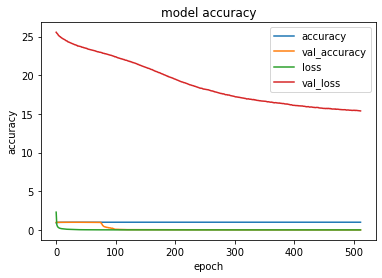

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'])
plt.show()

In [19]:
# 需要儲存article_id, 轉成dataframe
def predicting_txt_to_dataframe(path):    
    with open(path, 'r') as f:
        txt = str(f.read())
        txt_list = txt.split('\n')
    row_list = list()
    tmp_list = list()
    for row in txt_list:
        if row == '--------------------':
            tmp_list[0] = tmp_list[0].replace('article_id:', '')
            tmp_list[0] = int(tmp_list[0])
            row_list.append(tmp_list)
            tmp_list = list()
            continue
        if len(row) > 0:
            tmp_list.append(row)
    df = pd.DataFrame(row_list, columns=['article_id','text'])
    return df

In [20]:
def predict_NER(text):
    x_list = list()    
    text_list = re.split('\uff0c|\u3002|\uff1f', text)
    for article in text_list:
        x_list.append([i for i in article])
    y_list_list = model.predict(x_list)
    y_list = list()
    for sentence in y_list_list:
        for word in sentence:
            y_list.append(word)
        y_list.append('O') # append(，。？)
    y_list = y_list[:-1]
    return y_list

In [21]:
def output_NER(article_id, text, y_list):
    output_str = str()
    flag = False
    for i, j in enumerate(y_list):
        if j != 'O':
            if j[0] == 'B':
                start_position = i
                entity_type = j.split('-')[-1]
                flag = True
        elif j == 'O' and flag == True:
            end_position = i
            flag = False
            entity_text = text[start_position: end_position]
            entity = '{}\t{}\t{}\t{}\t{}\n'.format(article_id, start_position, end_position, entity_text, entity_type)  
            output_str += entity
    return output_str

In [22]:
df = predicting_txt_to_dataframe('/home/Danny/AI-CUP-2020/datasets/stage5/test.txt')
output_str = "article_id\tstart_position\tend_position\tentity_text\tentity_type\n"

for article_id, text in zip(df['article_id'], df['text']):
    x_list = [word for word in text]
    y_list = predict_NER(text)
    output_str += output_NER(article_id, text, y_list)

2020-12-17 22:15:56,132 [DEBUG] kashgari - predict seq_length: None, input: (2, 70, 17)


3/3 [==============================] - 0s 20ms/step


2020-12-17 22:15:59,085 [DEBUG] kashgari - predict output: (70, 17)
2020-12-17 22:15:59,086 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 0 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:15:59,088 [DEBUG] kashgari - predict seq_length: None, input: (2, 131, 28)


5/5 [==============================] - 0s 35ms/step


2020-12-17 22:16:02,165 [DEBUG] kashgari - predict output: (131, 28)
2020-12-17 22:16:02,166 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 4 2 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:16:02,170 [DEBUG] kashgari - predict seq_length: None, input: (2, 198, 47)


7/7 [==============================] - 0s 55ms/step


2020-12-17 22:16:05,413 [DEBUG] kashgari - predict output: (198, 47)
2020-12-17 22:16:05,414 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]
2020-12-17 22:16:05,416 [DEBUG] kashgari - predict seq_length: None, input: (2, 96, 41)


3/3 [==============================] - 0s 34ms/step


2020-12-17 22:16:07,918 [DEBUG] kashgari - predict output: (96, 41)
2020-12-17 22:16:07,919 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:16:07,920 [DEBUG] kashgari - predict seq_length: None, input: (2, 73, 17)


3/3 [==============================] - 0s 20ms/step


2020-12-17 22:16:08,035 [DEBUG] kashgari - predict output: (73, 17)
2020-12-17 22:16:08,036 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1 19 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ...  1  1  1]
 [ 0  1  0 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-17 22:16:08,040 [DEBUG] kashgari - predict seq_length: None, input: (2, 266, 23)


9/9 [==============================] - 0s 37ms/step


2020-12-17 22:16:11,260 [DEBUG] kashgari - predict output: (266, 23)
2020-12-17 22:16:11,261 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]
2020-12-17 22:16:11,265 [DEBUG] kashgari - predict seq_length: None, input: (2, 308, 21)


10/10 [==============================] - 0s 34ms/step


2020-12-17 22:16:14,310 [DEBUG] kashgari - predict output: (308, 21)
2020-12-17 22:16:14,311 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:16:14,315 [DEBUG] kashgari - predict seq_length: None, input: (2, 139, 38)


5/5 [==============================] - 0s 44ms/step


2020-12-17 22:16:17,510 [DEBUG] kashgari - predict output: (139, 38)
2020-12-17 22:16:17,511 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:16:17,513 [DEBUG] kashgari - predict seq_length: None, input: (2, 167, 22)


6/6 [==============================] - 0s 32ms/step


2020-12-17 22:16:20,643 [DEBUG] kashgari - predict output: (167, 22)
2020-12-17 22:16:20,644 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 9 9 9]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 2 2 2]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:16:20,649 [DEBUG] kashgari - predict seq_length: None, input: (2, 272, 41)


9/9 [==============================] - 0s 52ms/step


2020-12-17 22:16:23,906 [DEBUG] kashgari - predict output: (272, 41)
2020-12-17 22:16:23,907 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  9  9  9]
 [ 0  1 11 ...  8  8  8]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-17 22:16:23,910 [DEBUG] kashgari - predict seq_length: None, input: (2, 143, 63)


5/5 [==============================] - 0s 64ms/step


2020-12-17 22:16:27,732 [DEBUG] kashgari - predict output: (143, 63)
2020-12-17 22:16:27,733 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:16:27,739 [DEBUG] kashgari - predict seq_length: None, input: (2, 663, 42)


21/21 [==============================] - 1s 54ms/step


2020-12-17 22:16:31,713 [DEBUG] kashgari - predict output: (663, 42)
2020-12-17 22:16:31,714 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:16:31,716 [DEBUG] kashgari - predict seq_length: None, input: (2, 39, 25)


2/2 [==============================] - 0s 15ms/step


2020-12-17 22:16:34,453 [DEBUG] kashgari - predict output: (39, 25)
2020-12-17 22:16:34,456 [DEBUG] kashgari - predict output argmax: [[ 0  1  1  1  1  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1]
 [ 0  1  1  1  1  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0  1  1  1  1  1  1  1
   1]
 [ 0  1  1  1  1  1  1  1  1  1  1  0  1  1  1  1  1  1  1  1  1  1  1  1
   1]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  0  1  1  1  1  1  1  1  1  1  1  1
   1]
 [ 0  1  1  1  1  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1]
 [ 0  1  1  1  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1]
 [ 0  1  1  1  1  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1]
 [ 0  1  1  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  0  1  1  1  1  1  1  1  1  1  1  1
   1]
 [ 0  1  1  1  1  1  1  1  1  1  0  1  1  1  1  1  1  1  1  1  1  

6/6 [==============================] - 0s 32ms/step


2020-12-17 22:16:34,712 [DEBUG] kashgari - predict output: (175, 22)
2020-12-17 22:16:34,712 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:16:34,715 [DEBUG] kashgari - predict seq_length: None, input: (2, 143, 28)


5/5 [==============================] - 0s 33ms/step


2020-12-17 22:16:34,944 [DEBUG] kashgari - predict output: (143, 28)
2020-12-17 22:16:34,945 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:16:34,947 [DEBUG] kashgari - predict seq_length: None, input: (2, 88, 21)


3/3 [==============================] - 0s 22ms/step


2020-12-17 22:16:35,069 [DEBUG] kashgari - predict output: (88, 21)
2020-12-17 22:16:35,070 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:16:35,072 [DEBUG] kashgari - predict seq_length: None, input: (2, 121, 28)


4/4 [==============================] - 0s 30ms/step


2020-12-17 22:16:35,254 [DEBUG] kashgari - predict output: (121, 28)
2020-12-17 22:16:35,254 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:16:35,257 [DEBUG] kashgari - predict seq_length: None, input: (2, 85, 27)


3/3 [==============================] - 0s 29ms/step


2020-12-17 22:16:38,072 [DEBUG] kashgari - predict output: (85, 27)
2020-12-17 22:16:38,073 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:16:38,077 [DEBUG] kashgari - predict seq_length: None, input: (2, 255, 19)


8/8 [==============================] - 0s 34ms/step


2020-12-17 22:16:41,120 [DEBUG] kashgari - predict output: (255, 19)
2020-12-17 22:16:41,121 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:16:41,126 [DEBUG] kashgari - predict seq_length: None, input: (2, 202, 29)


7/7 [==============================] - 0s 38ms/step


2020-12-17 22:16:44,143 [DEBUG] kashgari - predict output: (202, 29)
2020-12-17 22:16:44,144 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:16:44,147 [DEBUG] kashgari - predict seq_length: None, input: (2, 198, 19)


7/7 [==============================] - 0s 28ms/step


2020-12-17 22:16:44,396 [DEBUG] kashgari - predict output: (198, 19)
2020-12-17 22:16:44,397 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0 18 10 ... 10 10 10]
 [ 0  1  1 ... 10 10 10]
 [ 0  0  0 ...  0  0  0]]
2020-12-17 22:16:44,400 [DEBUG] kashgari - predict seq_length: None, input: (2, 102, 39)


4/4 [==============================] - 0s 39ms/step


2020-12-17 22:16:47,286 [DEBUG] kashgari - predict output: (102, 39)
2020-12-17 22:16:47,287 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:16:47,290 [DEBUG] kashgari - predict seq_length: None, input: (2, 72, 36)


3/3 [==============================] - 0s 30ms/step


2020-12-17 22:16:51,003 [DEBUG] kashgari - predict output: (72, 36)
2020-12-17 22:16:51,003 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:16:51,008 [DEBUG] kashgari - predict seq_length: None, input: (2, 246, 27)


8/8 [==============================] - 0s 38ms/step


2020-12-17 22:16:51,384 [DEBUG] kashgari - predict output: (246, 27)
2020-12-17 22:16:51,384 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:16:51,387 [DEBUG] kashgari - predict seq_length: None, input: (2, 57, 34)


2/2 [==============================] - 0s 26ms/step


2020-12-17 22:16:54,186 [DEBUG] kashgari - predict output: (57, 34)
2020-12-17 22:16:54,187 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:16:54,188 [DEBUG] kashgari - predict seq_length: None, input: (2, 82, 21)


3/3 [==============================] - 0s 25ms/step


2020-12-17 22:16:54,322 [DEBUG] kashgari - predict output: (82, 21)
2020-12-17 22:16:54,323 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:16:54,327 [DEBUG] kashgari - predict seq_length: None, input: (2, 185, 32)


6/6 [==============================] - 0s 43ms/step


2020-12-17 22:16:57,483 [DEBUG] kashgari - predict output: (185, 32)
2020-12-17 22:16:57,484 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:16:57,486 [DEBUG] kashgari - predict seq_length: None, input: (2, 148, 28)


5/5 [==============================] - 0s 33ms/step


2020-12-17 22:16:57,714 [DEBUG] kashgari - predict output: (148, 28)
2020-12-17 22:16:57,715 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:16:57,719 [DEBUG] kashgari - predict seq_length: None, input: (2, 281, 23)


9/9 [==============================] - 0s 34ms/step


2020-12-17 22:16:58,081 [DEBUG] kashgari - predict output: (281, 23)
2020-12-17 22:16:58,082 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:16:58,084 [DEBUG] kashgari - predict seq_length: None, input: (2, 116, 20)


4/4 [==============================] - 0s 29ms/step


2020-12-17 22:17:00,946 [DEBUG] kashgari - predict output: (116, 20)
2020-12-17 22:17:00,947 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:00,950 [DEBUG] kashgari - predict seq_length: None, input: (2, 168, 25)


6/6 [==============================] - 0s 33ms/step


2020-12-17 22:17:01,214 [DEBUG] kashgari - predict output: (168, 25)
2020-12-17 22:17:01,215 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 4 2 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:01,219 [DEBUG] kashgari - predict seq_length: None, input: (2, 218, 30)


7/7 [==============================] - 0s 42ms/step


2020-12-17 22:17:04,259 [DEBUG] kashgari - predict output: (218, 30)
2020-12-17 22:17:04,260 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:04,263 [DEBUG] kashgari - predict seq_length: None, input: (2, 123, 32)


4/4 [==============================] - 0s 35ms/step


2020-12-17 22:17:04,476 [DEBUG] kashgari - predict output: (123, 32)
2020-12-17 22:17:04,477 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:04,479 [DEBUG] kashgari - predict seq_length: None, input: (2, 82, 21)


3/3 [==============================] - 0s 22ms/step


2020-12-17 22:17:04,598 [DEBUG] kashgari - predict output: (82, 21)
2020-12-17 22:17:04,599 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 4 2 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:04,601 [DEBUG] kashgari - predict seq_length: None, input: (2, 95, 19)


3/3 [==============================] - 0s 22ms/step


2020-12-17 22:17:04,719 [DEBUG] kashgari - predict output: (95, 19)
2020-12-17 22:17:04,720 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 4 2 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:04,724 [DEBUG] kashgari - predict seq_length: None, input: (2, 245, 24)


8/8 [==============================] - 0s 38ms/step


2020-12-17 22:17:07,766 [DEBUG] kashgari - predict output: (245, 24)
2020-12-17 22:17:07,767 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0 20  8 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-17 22:17:07,770 [DEBUG] kashgari - predict seq_length: None, input: (2, 126, 31)


4/4 [==============================] - 0s 39ms/step


2020-12-17 22:17:10,670 [DEBUG] kashgari - predict output: (126, 31)
2020-12-17 22:17:10,671 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  2  2  2]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0 20  8 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-17 22:17:10,673 [DEBUG] kashgari - predict seq_length: None, input: (2, 64, 19)


2/2 [==============================] - 0s 15ms/step


2020-12-17 22:17:12,635 [DEBUG] kashgari - predict output: (64, 19)
2020-12-17 22:17:12,635 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:12,637 [DEBUG] kashgari - predict seq_length: None, input: (2, 93, 24)


3/3 [==============================] - 0s 29ms/step


2020-12-17 22:17:12,791 [DEBUG] kashgari - predict output: (93, 24)
2020-12-17 22:17:12,792 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:12,795 [DEBUG] kashgari - predict seq_length: None, input: (2, 214, 16)


7/7 [==============================] - 0s 29ms/step


2020-12-17 22:17:15,696 [DEBUG] kashgari - predict output: (214, 16)
2020-12-17 22:17:15,697 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:15,699 [DEBUG] kashgari - predict seq_length: None, input: (2, 53, 20)


2/2 [==============================] - 0s 18ms/step


2020-12-17 22:17:15,795 [DEBUG] kashgari - predict output: (53, 20)
2020-12-17 22:17:15,796 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:15,803 [DEBUG] kashgari - predict seq_length: None, input: (2, 384, 18)


12/12 [==============================] - 0s 24ms/step


2020-12-17 22:17:18,916 [DEBUG] kashgari - predict output: (384, 18)
2020-12-17 22:17:18,917 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:18,919 [DEBUG] kashgari - predict seq_length: None, input: (2, 172, 24)


6/6 [==============================] - 0s 30ms/step


2020-12-17 22:17:19,156 [DEBUG] kashgari - predict output: (172, 24)
2020-12-17 22:17:19,157 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 9 9 9]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:19,159 [DEBUG] kashgari - predict seq_length: None, input: (2, 114, 24)


4/4 [==============================] - 0s 26ms/step


2020-12-17 22:17:19,323 [DEBUG] kashgari - predict output: (114, 24)
2020-12-17 22:17:19,324 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 2 2 2]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:19,327 [DEBUG] kashgari - predict seq_length: None, input: (2, 111, 47)


4/4 [==============================] - 0s 44ms/step


2020-12-17 22:17:19,589 [DEBUG] kashgari - predict output: (111, 47)
2020-12-17 22:17:19,590 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:19,594 [DEBUG] kashgari - predict seq_length: None, input: (2, 350, 34)


11/11 [==============================] - 0s 43ms/step


2020-12-17 22:17:20,141 [DEBUG] kashgari - predict output: (350, 34)
2020-12-17 22:17:20,142 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ... 22 22 22]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-17 22:17:20,143 [DEBUG] kashgari - predict seq_length: None, input: (2, 56, 20)


2/2 [==============================] - 0s 16ms/step


2020-12-17 22:17:20,228 [DEBUG] kashgari - predict output: (56, 20)
2020-12-17 22:17:20,228 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:20,231 [DEBUG] kashgari - predict seq_length: None, input: (2, 131, 17)


5/5 [==============================] - 0s 24ms/step


2020-12-17 22:17:20,408 [DEBUG] kashgari - predict output: (131, 17)
2020-12-17 22:17:20,409 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:20,413 [DEBUG] kashgari - predict seq_length: None, input: (2, 184, 34)


6/6 [==============================] - 0s 38ms/step


2020-12-17 22:17:20,711 [DEBUG] kashgari - predict output: (184, 34)
2020-12-17 22:17:20,712 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:20,715 [DEBUG] kashgari - predict seq_length: None, input: (2, 133, 51)


5/5 [==============================] - 0s 52ms/step


2020-12-17 22:17:23,926 [DEBUG] kashgari - predict output: (133, 51)
2020-12-17 22:17:23,927 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:23,931 [DEBUG] kashgari - predict seq_length: None, input: (2, 210, 53)


7/7 [==============================] - 0s 62ms/step


2020-12-17 22:17:27,337 [DEBUG] kashgari - predict output: (210, 53)
2020-12-17 22:17:27,337 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 9 9 9]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:27,340 [DEBUG] kashgari - predict seq_length: None, input: (2, 193, 55)


7/7 [==============================] - 0s 59ms/step


2020-12-17 22:17:30,735 [DEBUG] kashgari - predict output: (193, 55)
2020-12-17 22:17:30,736 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0 19  9 ...  8  8  8]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-17 22:17:30,737 [DEBUG] kashgari - predict seq_length: None, input: (2, 75, 30)


3/3 [==============================] - 0s 24ms/step


2020-12-17 22:17:30,871 [DEBUG] kashgari - predict output: (75, 30)
2020-12-17 22:17:30,872 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 0 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:30,876 [DEBUG] kashgari - predict seq_length: None, input: (2, 280, 46)


9/9 [==============================] - 1s 60ms/step


2020-12-17 22:17:34,358 [DEBUG] kashgari - predict output: (280, 46)
2020-12-17 22:17:34,358 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:34,361 [DEBUG] kashgari - predict seq_length: None, input: (2, 210, 20)


7/7 [==============================] - 0s 29ms/step


2020-12-17 22:17:34,615 [DEBUG] kashgari - predict output: (210, 20)
2020-12-17 22:17:34,616 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:34,620 [DEBUG] kashgari - predict seq_length: None, input: (2, 176, 24)


6/6 [==============================] - 0s 31ms/step


2020-12-17 22:17:34,862 [DEBUG] kashgari - predict output: (176, 24)
2020-12-17 22:17:34,863 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:34,867 [DEBUG] kashgari - predict seq_length: None, input: (2, 218, 25)


7/7 [==============================] - 0s 33ms/step


2020-12-17 22:17:35,156 [DEBUG] kashgari - predict output: (218, 25)
2020-12-17 22:17:35,156 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:35,159 [DEBUG] kashgari - predict seq_length: None, input: (2, 91, 23)


3/3 [==============================] - 0s 25ms/step


2020-12-17 22:17:35,294 [DEBUG] kashgari - predict output: (91, 23)
2020-12-17 22:17:35,295 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:35,299 [DEBUG] kashgari - predict seq_length: None, input: (2, 194, 28)


7/7 [==============================] - 0s 34ms/step


2020-12-17 22:17:35,602 [DEBUG] kashgari - predict output: (194, 28)
2020-12-17 22:17:35,603 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 7 7 7]
 ...
 [0 4 2 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:35,606 [DEBUG] kashgari - predict seq_length: None, input: (2, 179, 23)


6/6 [==============================] - 0s 31ms/step


2020-12-17 22:17:35,852 [DEBUG] kashgari - predict output: (179, 23)
2020-12-17 22:17:35,853 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:35,857 [DEBUG] kashgari - predict seq_length: None, input: (2, 234, 40)


8/8 [==============================] - 0s 47ms/step


2020-12-17 22:17:39,083 [DEBUG] kashgari - predict output: (234, 40)
2020-12-17 22:17:39,084 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:39,087 [DEBUG] kashgari - predict seq_length: None, input: (2, 250, 26)


8/8 [==============================] - 0s 40ms/step


2020-12-17 22:17:42,346 [DEBUG] kashgari - predict output: (250, 26)
2020-12-17 22:17:42,347 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:42,349 [DEBUG] kashgari - predict seq_length: None, input: (2, 170, 43)


6/6 [==============================] - 0s 48ms/step


2020-12-17 22:17:45,396 [DEBUG] kashgari - predict output: (170, 43)
2020-12-17 22:17:45,397 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:45,400 [DEBUG] kashgari - predict seq_length: None, input: (2, 145, 34)


5/5 [==============================] - 0s 37ms/step


2020-12-17 22:17:45,654 [DEBUG] kashgari - predict output: (145, 34)
2020-12-17 22:17:45,655 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 9 9 9]
 [0 4 2 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:45,656 [DEBUG] kashgari - predict seq_length: None, input: (2, 102, 29)


4/4 [==============================] - 0s 28ms/step


2020-12-17 22:17:45,830 [DEBUG] kashgari - predict output: (102, 29)
2020-12-17 22:17:45,830 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:45,836 [DEBUG] kashgari - predict seq_length: None, input: (2, 340, 20)


11/11 [==============================] - 0s 30ms/step


2020-12-17 22:17:46,223 [DEBUG] kashgari - predict output: (340, 20)
2020-12-17 22:17:46,224 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:46,226 [DEBUG] kashgari - predict seq_length: None, input: (2, 122, 23)


4/4 [==============================] - 0s 28ms/step


2020-12-17 22:17:46,399 [DEBUG] kashgari - predict output: (122, 23)
2020-12-17 22:17:46,400 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 9 9 9]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:46,405 [DEBUG] kashgari - predict seq_length: None, input: (2, 381, 28)


12/12 [==============================] - 0s 38ms/step


2020-12-17 22:17:46,929 [DEBUG] kashgari - predict output: (381, 28)
2020-12-17 22:17:46,930 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:46,933 [DEBUG] kashgari - predict seq_length: None, input: (2, 244, 27)


8/8 [==============================] - 0s 36ms/step


2020-12-17 22:17:47,281 [DEBUG] kashgari - predict output: (244, 27)
2020-12-17 22:17:47,282 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:47,285 [DEBUG] kashgari - predict seq_length: None, input: (2, 91, 46)


3/3 [==============================] - 0s 41ms/step


2020-12-17 22:17:47,491 [DEBUG] kashgari - predict output: (91, 46)
2020-12-17 22:17:47,492 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:47,496 [DEBUG] kashgari - predict seq_length: None, input: (2, 223, 42)


7/7 [==============================] - 0s 48ms/step


2020-12-17 22:17:47,909 [DEBUG] kashgari - predict output: (223, 42)
2020-12-17 22:17:47,909 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:47,911 [DEBUG] kashgari - predict seq_length: None, input: (2, 146, 25)


5/5 [==============================] - 0s 30ms/step


2020-12-17 22:17:48,123 [DEBUG] kashgari - predict output: (146, 25)
2020-12-17 22:17:48,123 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:48,127 [DEBUG] kashgari - predict seq_length: None, input: (2, 162, 23)


6/6 [==============================] - 0s 30ms/step


2020-12-17 22:17:48,362 [DEBUG] kashgari - predict output: (162, 23)
2020-12-17 22:17:48,363 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:48,366 [DEBUG] kashgari - predict seq_length: None, input: (2, 244, 27)


8/8 [==============================] - 0s 35ms/step


2020-12-17 22:17:48,718 [DEBUG] kashgari - predict output: (244, 27)
2020-12-17 22:17:48,719 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0 19  9 ...  9  9  9]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  0  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-17 22:17:48,721 [DEBUG] kashgari - predict seq_length: None, input: (2, 170, 18)


6/6 [==============================] - 0s 29ms/step


2020-12-17 22:17:51,903 [DEBUG] kashgari - predict output: (170, 18)
2020-12-17 22:17:51,904 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 0 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:51,908 [DEBUG] kashgari - predict seq_length: None, input: (2, 199, 36)


7/7 [==============================] - 0s 40ms/step


2020-12-17 22:17:52,271 [DEBUG] kashgari - predict output: (199, 36)
2020-12-17 22:17:52,272 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:52,276 [DEBUG] kashgari - predict seq_length: None, input: (2, 557, 17)


18/18 [==============================] - 1s 30ms/step


2020-12-17 22:17:52,876 [DEBUG] kashgari - predict output: (557, 17)
2020-12-17 22:17:52,877 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  0 ...  1  1  1]
 [ 0 19  9 ...  9  9  9]
 ...
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-17 22:17:52,882 [DEBUG] kashgari - predict seq_length: None, input: (2, 278, 42)


9/9 [==============================] - 0s 50ms/step


2020-12-17 22:17:53,409 [DEBUG] kashgari - predict output: (278, 42)
2020-12-17 22:17:53,410 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:53,412 [DEBUG] kashgari - predict seq_length: None, input: (2, 91, 19)


3/3 [==============================] - 0s 22ms/step


2020-12-17 22:17:53,536 [DEBUG] kashgari - predict output: (91, 19)
2020-12-17 22:17:53,537 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:53,542 [DEBUG] kashgari - predict seq_length: None, input: (2, 296, 24)


10/10 [==============================] - 0s 34ms/step


2020-12-17 22:17:53,939 [DEBUG] kashgari - predict output: (296, 24)
2020-12-17 22:17:53,940 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:53,942 [DEBUG] kashgari - predict seq_length: None, input: (2, 154, 48)


5/5 [==============================] - 0s 58ms/step


2020-12-17 22:17:57,191 [DEBUG] kashgari - predict output: (154, 48)
2020-12-17 22:17:57,192 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:17:57,195 [DEBUG] kashgari - predict seq_length: None, input: (2, 206, 37)


7/7 [==============================] - 0s 47ms/step


2020-12-17 22:18:00,314 [DEBUG] kashgari - predict output: (206, 37)
2020-12-17 22:18:00,315 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ...  1  1  1]
 [ 0  1 19 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-17 22:18:00,318 [DEBUG] kashgari - predict seq_length: None, input: (2, 241, 20)


8/8 [==============================] - 0s 28ms/step


2020-12-17 22:18:00,600 [DEBUG] kashgari - predict output: (241, 20)
2020-12-17 22:18:00,601 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 4 2 ... 2 2 2]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:00,608 [DEBUG] kashgari - predict seq_length: None, input: (2, 459, 31)


15/15 [==============================] - 1s 41ms/step


2020-12-17 22:18:01,298 [DEBUG] kashgari - predict output: (459, 31)
2020-12-17 22:18:01,298 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:01,302 [DEBUG] kashgari - predict seq_length: None, input: (2, 223, 34)


7/7 [==============================] - 0s 41ms/step


2020-12-17 22:18:01,662 [DEBUG] kashgari - predict output: (223, 34)
2020-12-17 22:18:01,663 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:01,667 [DEBUG] kashgari - predict seq_length: None, input: (2, 358, 26)


12/12 [==============================] - 0s 37ms/step


2020-12-17 22:18:02,171 [DEBUG] kashgari - predict output: (358, 26)
2020-12-17 22:18:02,172 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:02,174 [DEBUG] kashgari - predict seq_length: None, input: (2, 72, 20)


3/3 [==============================] - 0s 19ms/step


2020-12-17 22:18:02,284 [DEBUG] kashgari - predict output: (72, 20)
2020-12-17 22:18:02,285 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:02,287 [DEBUG] kashgari - predict seq_length: None, input: (2, 75, 24)


3/3 [==============================] - 0s 21ms/step


2020-12-17 22:18:02,409 [DEBUG] kashgari - predict output: (75, 24)
2020-12-17 22:18:02,410 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:02,414 [DEBUG] kashgari - predict seq_length: None, input: (2, 191, 36)


6/6 [==============================] - 0s 42ms/step


2020-12-17 22:18:02,736 [DEBUG] kashgari - predict output: (191, 36)
2020-12-17 22:18:02,737 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:02,740 [DEBUG] kashgari - predict seq_length: None, input: (2, 149, 19)


5/5 [==============================] - 0s 26ms/step


2020-12-17 22:18:02,919 [DEBUG] kashgari - predict output: (149, 19)
2020-12-17 22:18:02,920 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  9  9  9]
 [ 0  1  1 ... 22 22 22]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-17 22:18:02,923 [DEBUG] kashgari - predict seq_length: None, input: (2, 176, 22)


6/6 [==============================] - 0s 28ms/step


2020-12-17 22:18:03,147 [DEBUG] kashgari - predict output: (176, 22)
2020-12-17 22:18:03,148 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 4 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:03,151 [DEBUG] kashgari - predict seq_length: None, input: (2, 112, 45)


4/4 [==============================] - 0s 49ms/step


2020-12-17 22:18:07,198 [DEBUG] kashgari - predict output: (112, 45)
2020-12-17 22:18:07,199 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:07,201 [DEBUG] kashgari - predict seq_length: None, input: (2, 269, 21)


9/9 [==============================] - 0s 30ms/step


2020-12-17 22:18:07,538 [DEBUG] kashgari - predict output: (269, 21)
2020-12-17 22:18:07,539 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:07,541 [DEBUG] kashgari - predict seq_length: None, input: (2, 112, 18)


4/4 [==============================] - 0s 23ms/step


2020-12-17 22:18:07,681 [DEBUG] kashgari - predict output: (112, 18)
2020-12-17 22:18:07,682 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ...  1  1  1]
 [ 0  1 11 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-17 22:18:07,686 [DEBUG] kashgari - predict seq_length: None, input: (2, 352, 22)


11/11 [==============================] - 0s 27ms/step


2020-12-17 22:18:09,925 [DEBUG] kashgari - predict output: (352, 22)
2020-12-17 22:18:09,926 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:09,930 [DEBUG] kashgari - predict seq_length: None, input: (2, 243, 24)


8/8 [==============================] - 0s 33ms/step


2020-12-17 22:18:10,258 [DEBUG] kashgari - predict output: (243, 24)
2020-12-17 22:18:10,259 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:10,263 [DEBUG] kashgari - predict seq_length: None, input: (2, 340, 27)


11/11 [==============================] - 0s 37ms/step


2020-12-17 22:18:10,730 [DEBUG] kashgari - predict output: (340, 27)
2020-12-17 22:18:10,730 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:10,735 [DEBUG] kashgari - predict seq_length: None, input: (2, 384, 25)


12/12 [==============================] - 0s 31ms/step


2020-12-17 22:18:13,030 [DEBUG] kashgari - predict output: (384, 25)
2020-12-17 22:18:13,030 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:13,034 [DEBUG] kashgari - predict seq_length: None, input: (2, 112, 36)


4/4 [==============================] - 0s 35ms/step


2020-12-17 22:18:13,242 [DEBUG] kashgari - predict output: (112, 36)
2020-12-17 22:18:13,242 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:13,245 [DEBUG] kashgari - predict seq_length: None, input: (2, 222, 28)


7/7 [==============================] - 0s 36ms/step


2020-12-17 22:18:13,561 [DEBUG] kashgari - predict output: (222, 28)
2020-12-17 22:18:13,562 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:13,566 [DEBUG] kashgari - predict seq_length: None, input: (2, 255, 34)


8/8 [==============================] - 0s 42ms/step


2020-12-17 22:18:13,968 [DEBUG] kashgari - predict output: (255, 34)
2020-12-17 22:18:13,969 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:13,970 [DEBUG] kashgari - predict seq_length: None, input: (2, 67, 25)


3/3 [==============================] - 0s 22ms/step


2020-12-17 22:18:14,090 [DEBUG] kashgari - predict output: (67, 25)
2020-12-17 22:18:14,091 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 4 2 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:14,093 [DEBUG] kashgari - predict seq_length: None, input: (2, 77, 53)


3/3 [==============================] - 0s 38ms/step


2020-12-17 22:18:14,297 [DEBUG] kashgari - predict output: (77, 53)
2020-12-17 22:18:14,297 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:14,299 [DEBUG] kashgari - predict seq_length: None, input: (2, 67, 27)


3/3 [==============================] - 0s 23ms/step


2020-12-17 22:18:14,427 [DEBUG] kashgari - predict output: (67, 27)
2020-12-17 22:18:14,427 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 8 8 8]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:14,429 [DEBUG] kashgari - predict seq_length: None, input: (2, 72, 19)


3/3 [==============================] - 0s 19ms/step


2020-12-17 22:18:14,539 [DEBUG] kashgari - predict output: (72, 19)
2020-12-17 22:18:14,539 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:14,542 [DEBUG] kashgari - predict seq_length: None, input: (2, 98, 24)


4/4 [==============================] - 0s 26ms/step


2020-12-17 22:18:14,703 [DEBUG] kashgari - predict output: (98, 24)
2020-12-17 22:18:14,704 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:14,706 [DEBUG] kashgari - predict seq_length: None, input: (2, 87, 37)


3/3 [==============================] - 0s 32ms/step


2020-12-17 22:18:14,873 [DEBUG] kashgari - predict output: (87, 37)
2020-12-17 22:18:14,874 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:14,882 [DEBUG] kashgari - predict seq_length: None, input: (2, 311, 29)


10/10 [==============================] - 0s 38ms/step


2020-12-17 22:18:15,326 [DEBUG] kashgari - predict output: (311, 29)
2020-12-17 22:18:15,326 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:15,331 [DEBUG] kashgari - predict seq_length: None, input: (2, 447, 20)


14/14 [==============================] - 0s 32ms/step


2020-12-17 22:18:15,831 [DEBUG] kashgari - predict output: (447, 20)
2020-12-17 22:18:15,832 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:15,835 [DEBUG] kashgari - predict seq_length: None, input: (2, 218, 19)


7/7 [==============================] - 0s 28ms/step


2020-12-17 22:18:16,087 [DEBUG] kashgari - predict output: (218, 19)
2020-12-17 22:18:16,088 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:16,093 [DEBUG] kashgari - predict seq_length: None, input: (2, 285, 30)


9/9 [==============================] - 0s 39ms/step


2020-12-17 22:18:16,507 [DEBUG] kashgari - predict output: (285, 30)
2020-12-17 22:18:16,507 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 7 7 7]
 [0 1 1 ... 7 7 7]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:16,511 [DEBUG] kashgari - predict seq_length: None, input: (2, 424, 21)


14/14 [==============================] - 0s 32ms/step


2020-12-17 22:18:17,021 [DEBUG] kashgari - predict output: (424, 21)
2020-12-17 22:18:17,022 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:17,023 [DEBUG] kashgari - predict seq_length: None, input: (2, 94, 30)


3/3 [==============================] - 0s 29ms/step


2020-12-17 22:18:17,172 [DEBUG] kashgari - predict output: (94, 30)
2020-12-17 22:18:17,173 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:17,177 [DEBUG] kashgari - predict seq_length: None, input: (2, 202, 34)


7/7 [==============================] - 0s 39ms/step


2020-12-17 22:18:17,520 [DEBUG] kashgari - predict output: (202, 34)
2020-12-17 22:18:17,521 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:17,523 [DEBUG] kashgari - predict seq_length: None, input: (2, 242, 50)


8/8 [==============================] - 0s 60ms/step


2020-12-17 22:18:20,755 [DEBUG] kashgari - predict output: (242, 50)
2020-12-17 22:18:20,756 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]
2020-12-17 22:18:20,759 [DEBUG] kashgari - predict seq_length: None, input: (2, 269, 38)


9/9 [==============================] - 0s 46ms/step


2020-12-17 22:18:21,247 [DEBUG] kashgari - predict output: (269, 38)
2020-12-17 22:18:21,248 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:21,249 [DEBUG] kashgari - predict seq_length: None, input: (2, 108, 35)


4/4 [==============================] - 0s 39ms/step


2020-12-17 22:18:24,085 [DEBUG] kashgari - predict output: (108, 35)
2020-12-17 22:18:24,086 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:24,088 [DEBUG] kashgari - predict seq_length: None, input: (2, 136, 30)


5/5 [==============================] - 0s 34ms/step


2020-12-17 22:18:24,330 [DEBUG] kashgari - predict output: (136, 30)
2020-12-17 22:18:24,331 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:24,335 [DEBUG] kashgari - predict seq_length: None, input: (2, 217, 28)


7/7 [==============================] - 0s 35ms/step


2020-12-17 22:18:24,642 [DEBUG] kashgari - predict output: (217, 28)
2020-12-17 22:18:24,642 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:24,644 [DEBUG] kashgari - predict seq_length: None, input: (2, 83, 27)


3/3 [==============================] - 0s 26ms/step


2020-12-17 22:18:24,780 [DEBUG] kashgari - predict output: (83, 27)
2020-12-17 22:18:24,781 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:24,786 [DEBUG] kashgari - predict seq_length: None, input: (2, 392, 36)


13/13 [==============================] - 1s 45ms/step


2020-12-17 22:18:25,444 [DEBUG] kashgari - predict output: (392, 36)
2020-12-17 22:18:25,445 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:25,447 [DEBUG] kashgari - predict seq_length: None, input: (2, 108, 41)


4/4 [==============================] - 0s 37ms/step


2020-12-17 22:18:25,672 [DEBUG] kashgari - predict output: (108, 41)
2020-12-17 22:18:25,672 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:25,676 [DEBUG] kashgari - predict seq_length: None, input: (2, 221, 26)


7/7 [==============================] - 0s 35ms/step


2020-12-17 22:18:25,983 [DEBUG] kashgari - predict output: (221, 26)
2020-12-17 22:18:25,984 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:25,986 [DEBUG] kashgari - predict seq_length: None, input: (2, 94, 45)


3/3 [==============================] - 0s 40ms/step


2020-12-17 22:18:26,195 [DEBUG] kashgari - predict output: (94, 45)
2020-12-17 22:18:26,195 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:26,197 [DEBUG] kashgari - predict seq_length: None, input: (2, 59, 21)


2/2 [==============================] - 0s 17ms/step


2020-12-17 22:18:26,284 [DEBUG] kashgari - predict output: (59, 21)
2020-12-17 22:18:26,285 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:26,288 [DEBUG] kashgari - predict seq_length: None, input: (2, 101, 33)


4/4 [==============================] - 0s 35ms/step


2020-12-17 22:18:29,381 [DEBUG] kashgari - predict output: (101, 33)
2020-12-17 22:18:29,382 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:29,384 [DEBUG] kashgari - predict seq_length: None, input: (2, 64, 33)


2/2 [==============================] - 0s 23ms/step


2020-12-17 22:18:31,356 [DEBUG] kashgari - predict output: (64, 33)
2020-12-17 22:18:31,357 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 8 8 8]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:31,358 [DEBUG] kashgari - predict seq_length: None, input: (2, 85, 30)


3/3 [==============================] - 0s 30ms/step


2020-12-17 22:18:31,523 [DEBUG] kashgari - predict output: (85, 30)
2020-12-17 22:18:31,523 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:31,525 [DEBUG] kashgari - predict seq_length: None, input: (2, 89, 33)


3/3 [==============================] - 0s 31ms/step


2020-12-17 22:18:31,695 [DEBUG] kashgari - predict output: (89, 33)
2020-12-17 22:18:31,695 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:31,700 [DEBUG] kashgari - predict seq_length: None, input: (2, 254, 27)


8/8 [==============================] - 0s 36ms/step


2020-12-17 22:18:32,056 [DEBUG] kashgari - predict output: (254, 27)
2020-12-17 22:18:32,057 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 4 2 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:32,060 [DEBUG] kashgari - predict seq_length: None, input: (2, 129, 29)


5/5 [==============================] - 0s 30ms/step


2020-12-17 22:18:32,275 [DEBUG] kashgari - predict output: (129, 29)
2020-12-17 22:18:32,276 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:32,279 [DEBUG] kashgari - predict seq_length: None, input: (2, 130, 26)


5/5 [==============================] - 0s 29ms/step


2020-12-17 22:18:32,486 [DEBUG] kashgari - predict output: (130, 26)
2020-12-17 22:18:32,487 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ... 22 22 22]
 [ 0  0  0 ...  0  0  0]]
2020-12-17 22:18:32,490 [DEBUG] kashgari - predict seq_length: None, input: (2, 143, 37)


5/5 [==============================] - 0s 39ms/step


2020-12-17 22:18:32,763 [DEBUG] kashgari - predict output: (143, 37)
2020-12-17 22:18:32,764 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:32,767 [DEBUG] kashgari - predict seq_length: None, input: (2, 107, 36)


4/4 [==============================] - 0s 33ms/step


2020-12-17 22:18:32,967 [DEBUG] kashgari - predict output: (107, 36)
2020-12-17 22:18:32,968 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:32,970 [DEBUG] kashgari - predict seq_length: None, input: (2, 70, 28)


3/3 [==============================] - 0s 23ms/step


2020-12-17 22:18:33,100 [DEBUG] kashgari - predict output: (70, 28)
2020-12-17 22:18:33,101 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:33,105 [DEBUG] kashgari - predict seq_length: None, input: (2, 189, 26)


6/6 [==============================] - 0s 35ms/step


2020-12-17 22:18:33,379 [DEBUG] kashgari - predict output: (189, 26)
2020-12-17 22:18:33,380 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:33,383 [DEBUG] kashgari - predict seq_length: None, input: (2, 99, 48)


4/4 [==============================] - 0s 40ms/step


2020-12-17 22:18:33,628 [DEBUG] kashgari - predict output: (99, 48)
2020-12-17 22:18:33,629 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:33,633 [DEBUG] kashgari - predict seq_length: None, input: (2, 213, 35)


7/7 [==============================] - 0s 42ms/step


2020-12-17 22:18:33,999 [DEBUG] kashgari - predict output: (213, 35)
2020-12-17 22:18:34,000 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:34,004 [DEBUG] kashgari - predict seq_length: None, input: (2, 181, 40)


6/6 [==============================] - 0s 44ms/step


2020-12-17 22:18:34,344 [DEBUG] kashgari - predict output: (181, 40)
2020-12-17 22:18:34,345 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:34,347 [DEBUG] kashgari - predict seq_length: None, input: (2, 119, 34)


4/4 [==============================] - 0s 35ms/step


2020-12-17 22:18:34,554 [DEBUG] kashgari - predict output: (119, 34)
2020-12-17 22:18:34,555 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:34,559 [DEBUG] kashgari - predict seq_length: None, input: (2, 188, 52)


6/6 [==============================] - 0s 61ms/step


2020-12-17 22:18:37,852 [DEBUG] kashgari - predict output: (188, 52)
2020-12-17 22:18:37,853 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:37,858 [DEBUG] kashgari - predict seq_length: None, input: (2, 252, 30)


8/8 [==============================] - 0s 38ms/step


2020-12-17 22:18:38,228 [DEBUG] kashgari - predict output: (252, 30)
2020-12-17 22:18:38,228 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:38,231 [DEBUG] kashgari - predict seq_length: None, input: (2, 249, 38)


8/8 [==============================] - 0s 46ms/step


2020-12-17 22:18:38,675 [DEBUG] kashgari - predict output: (249, 38)
2020-12-17 22:18:38,676 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 4 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:38,678 [DEBUG] kashgari - predict seq_length: None, input: (2, 65, 44)


3/3 [==============================] - 0s 32ms/step


2020-12-17 22:18:41,707 [DEBUG] kashgari - predict output: (65, 44)
2020-12-17 22:18:41,708 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 8 8 8]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:41,715 [DEBUG] kashgari - predict seq_length: None, input: (2, 265, 41)


9/9 [==============================] - 0s 48ms/step


2020-12-17 22:18:42,239 [DEBUG] kashgari - predict output: (265, 41)
2020-12-17 22:18:42,240 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:42,242 [DEBUG] kashgari - predict seq_length: None, input: (2, 163, 33)


6/6 [==============================] - 0s 36ms/step


2020-12-17 22:18:42,529 [DEBUG] kashgari - predict output: (163, 33)
2020-12-17 22:18:42,529 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 1 1 ... 2 2 2]
 [0 1 1 ... 2 2 2]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:42,533 [DEBUG] kashgari - predict seq_length: None, input: (2, 166, 33)


6/6 [==============================] - 0s 36ms/step


2020-12-17 22:18:42,815 [DEBUG] kashgari - predict output: (166, 33)
2020-12-17 22:18:42,815 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  9  9  9]
 [ 0 20  8 ...  8  8  8]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-17 22:18:42,818 [DEBUG] kashgari - predict seq_length: None, input: (2, 152, 37)


5/5 [==============================] - 0s 40ms/step


2020-12-17 22:18:43,093 [DEBUG] kashgari - predict output: (152, 37)
2020-12-17 22:18:43,094 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:43,097 [DEBUG] kashgari - predict seq_length: None, input: (2, 129, 26)


5/5 [==============================] - 0s 29ms/step


2020-12-17 22:18:43,303 [DEBUG] kashgari - predict output: (129, 26)
2020-12-17 22:18:43,304 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:43,308 [DEBUG] kashgari - predict seq_length: None, input: (2, 260, 42)


9/9 [==============================] - 0s 47ms/step


2020-12-17 22:18:43,805 [DEBUG] kashgari - predict output: (260, 42)
2020-12-17 22:18:43,806 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:43,812 [DEBUG] kashgari - predict seq_length: None, input: (2, 557, 59)


18/18 [==============================] - 1s 72ms/step


2020-12-17 22:18:47,949 [DEBUG] kashgari - predict output: (557, 59)
2020-12-17 22:18:47,950 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ... 22 22 22]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-17 22:18:47,952 [DEBUG] kashgari - predict seq_length: None, input: (2, 144, 72)


5/5 [==============================] - 0s 72ms/step


2020-12-17 22:18:51,068 [DEBUG] kashgari - predict output: (144, 72)
2020-12-17 22:18:51,069 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:51,074 [DEBUG] kashgari - predict seq_length: None, input: (2, 474, 27)


15/15 [==============================] - 1s 38ms/step


2020-12-17 22:18:51,709 [DEBUG] kashgari - predict output: (474, 27)
2020-12-17 22:18:51,710 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:51,713 [DEBUG] kashgari - predict seq_length: None, input: (2, 253, 34)


8/8 [==============================] - 0s 42ms/step


2020-12-17 22:18:52,117 [DEBUG] kashgari - predict output: (253, 34)
2020-12-17 22:18:52,118 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:52,121 [DEBUG] kashgari - predict seq_length: None, input: (2, 210, 45)


7/7 [==============================] - 0s 52ms/step


2020-12-17 22:18:52,571 [DEBUG] kashgari - predict output: (210, 45)
2020-12-17 22:18:52,572 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:52,575 [DEBUG] kashgari - predict seq_length: None, input: (2, 244, 32)


8/8 [==============================] - 0s 39ms/step


2020-12-17 22:18:52,958 [DEBUG] kashgari - predict output: (244, 32)
2020-12-17 22:18:52,958 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:52,961 [DEBUG] kashgari - predict seq_length: None, input: (2, 319, 36)


10/10 [==============================] - 0s 45ms/step


2020-12-17 22:18:53,487 [DEBUG] kashgari - predict output: (319, 36)
2020-12-17 22:18:53,488 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:53,492 [DEBUG] kashgari - predict seq_length: None, input: (2, 437, 36)


14/14 [==============================] - 1s 46ms/step


2020-12-17 22:18:54,209 [DEBUG] kashgari - predict output: (437, 36)
2020-12-17 22:18:54,210 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-17 22:18:54,213 [DEBUG] kashgari - predict seq_length: None, input: (2, 171, 78)


6/6 [==============================] - 0s 78ms/step


2020-12-17 22:18:57,664 [DEBUG] kashgari - predict output: (171, 78)
2020-12-17 22:18:57,664 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]


In [23]:
output_path = 'output/duplicates_augmentation_{}_epoch_{}_batch_{}.tsv'.format(model_name, epochs, batch_size)
with open(output_path, 'w', encoding='utf-8') as f:
    f.write(output_str)

In [24]:
df = pd.read_csv(output_path, sep='\t')
df

,article_id,start_position,end_position,entity_text,entity_type
0,0,36,38,年底,time
1,0,227,229,麻豆,location
2,0,237,239,麻豆,location
3,1,15,18,這學期,time
4,1,40,42,昨天,time
...,...,...,...,...,...
2565,158,431,435,二十二十,time
2566,158,1082,1086,第三個月,time
2567,158,1143,1145,今天,time
2568,158,1199,1201,小安,name
